In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.python.saved_model import tag_constants
from time import perf_counter
import os

# limit VRAM usage
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# preserve GPU threads for better performance
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

In [2]:
# load YOLOv4 model, yolov4-416 or yolov4-tiny-416
model_path = "./checkpoints/yolov4-tiny-416"
model = tf.saved_model.load(model_path, tags=[tag_constants.SERVING])
infer = model.signatures['serving_default']

In [3]:
# load test image
image_path = "./data/cycling_park.jpg"
input_size = 416
original_image = cv2.imread(image_path)
H, W, _ = original_image.shape
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
image_data = cv2.resize(original_image, (input_size, input_size)) / 255.
image_data = tf.expand_dims(image_data.astype(np.float32), axis=0)

In [13]:
# get valid bounding boxes
tic = perf_counter()

pred_bbox = np.squeeze(infer(image_data)['tf.concat_12'])

boxes = pred_bbox[:, 0:4]
scores = pred_bbox[:, 4:]
human_indices = np.squeeze(np.argwhere(np.argmax(scores, axis=-1) == 0))
boxes = boxes[human_indices, :]
scores = scores[human_indices, 0]

selected_indices = tf.image.non_max_suppression(
    boxes=boxes,
    scores=scores,
    max_output_size=20,
    iou_threshold=0.45,
    score_threshold=0.25
)
 
boxes = boxes[selected_indices.numpy(), :]

# crop to bounding boxes
target_size = 71
targets = []
for box in (boxes * [H, W, H, W]).astype(np.int32):
    targets.append(cv2.resize(original_image[box[0]:box[2], box[1]:box[3], :], (target_size, target_size)).astype(np.float32))
    
elasped = perf_counter() - tic
print("Process time: %.2f ms" % (elasped*1000))
print("FPS: %.1f" % (1 / elasped))

Process time: 10.62 ms
FPS: 94.1


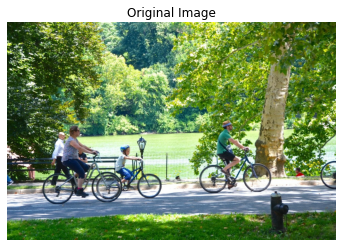

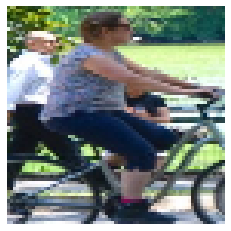

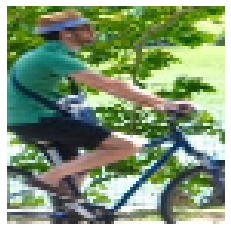

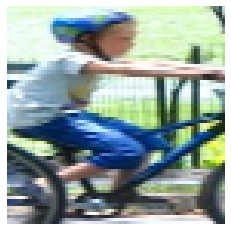

In [5]:
# display all cropped images
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')
plt.show()
for target in targets:
    plt.imshow(target.astype(np.uint8))
    plt.axis('off')
    plt.show()